In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
from torch.nn import functional as nnf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from collections import defaultdict
import numpy as np

In [3]:
data = pd.read_csv('mlp.csv')
# data = data.sample(300, random_state=1)
x = data['x'].to_numpy()
y = data['y'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=1)

In [2]:
# # data gen params
# N = 200
# # N = 256 # first experiment
# var = 0.8
# start = 1
# end = 30
# # end = 25 # first experiment
# split = 0.5
# seed = 42
# np.random.seed(seed)
# def f_x(x):
#     return np.sin(x) + np.log(x)

# # data
# x = np.linspace(start, end, N)
# y = f_x(x)
# noise = np.random.normal(0, var,N)
# y = y + noise
# x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.5, random_state=seed)

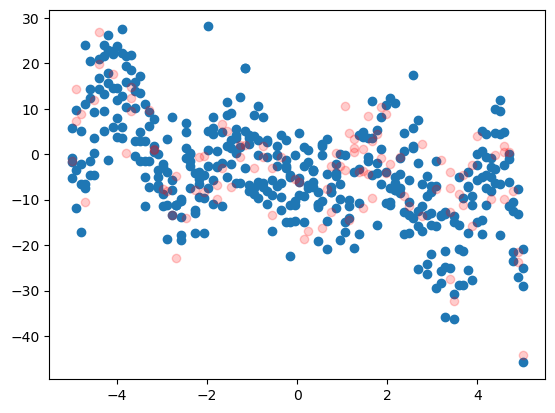

In [8]:
plt.scatter(x_train, y_train)
plt.scatter(x_val, y_val, c='red', alpha=0.2)
# x_gt = np.linspace(start, end, 1000)
# y_gt = f_x(x_gt)
# plt.plot(x_gt, y_gt, color='green')

In [51]:
class ToyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [52]:
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(1, 28)
#         self.linear2 = nn.Linear(1, 56)
#         self.linear2 = nn.Linear(1, 56)

# [64, 128, 256, 512, 256, 128, 64]


#     def forward(self, x):
#         return self.layers(x)

In [53]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, dropout_ratio=0.1):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())
                modules.append(nn.Dropout(dropout_ratio))

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

In [54]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    model.train()

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)

        if epoch % val_interval == 0:
            val_loss = validate(model, valloader, device)
            val_losses.append(val_loss)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

In [ ]:
# fixed training hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")
epochs = 5000
lr = 0.01
val_interval = 10
batch_size = 64

# hvaried training hyperparameters
dropout_ratios = [0, 0.1, 0.3, 0.6]
weight_decays = [0, 0.1, 0.01, 0.001]
hidden_layer_sizes = [[64, 128, 256, 128, 64],
               [32, 64, 128, 64, 32],
               [16, 32, 64, 32, 16],]
parameter_combinations = itertools.product(dropout_ratios, weight_decays, hidden_layer_sizes)

# fixed training objects
trainset = ToyDataset(x_train, y_train)
valset = ToyDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# experiment
experimental_results = defaultdict(list)
for combination in tqdm(parameter_combinations):
    dropout_ratio = combination[0]
    weight_decay = combination[1]
    layer_sizes = combination[2]
    experimental_results['dropout_ratio'].append(dropout_ratio)
    experimental_results['weight_decay'].append(weight_decay)
    experimental_results['layer_sizes'].append(layer_sizes)

    layer_sizes = [1] + layer_sizes + [1]
    model = MLP(layer_sizes=layer_sizes, dropout_ratio=dropout_ratio).to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device, val_interval)
    experimental_results['min_val_loss'].append(np.min(val_losses))

    # experimental_results_df = pd.DataFrame.from_dict(experimental_results)
    # experimental_results_df.to_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/experimental_results.pkl')


In [123]:
test = pd.read_pickle('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/experimental_results_2.pkl')
# test.iloc[test['min_val_loss'].argmin(), :]
test

,dropout_ratio,weight_decay,min_val_loss
0,0.0,0.000,1.018624
1,0.0,0.100,1.038623
2,0.0,0.010,0.996990
3,0.0,0.001,1.030731
4,0.1,0.000,1.038805
5,0.1,0.100,1.040566
6,0.1,0.010,1.043382
7,0.1,0.001,0.979537
8,0.3,0.000,0.982777
9,0.3,0.100,1.034828


# train best model

In [302]:
# fixed training hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")
epochs = 10000
lr = 0.001
val_interval = 10
batch_size = 128

# best hyperparameters from experiment
dropout_ratio = 0.1
# dropout_ratio = 0
weight_decay = 0.3
# weight_decay = 0
# layer_sizes = [28, 56, 112, 56, 28]
layer_sizes = [1, 64, 128, 256, 128, 64, 1]
# layer_sizes = [1] + layer_sizes + [1]

# fixed training objects
trainset = ToyDataset(x_train, y_train)
valset = ToyDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

model = MLP(layer_sizes=layer_sizes, dropout_ratio=dropout_ratio).to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device, val_interval=1, savepath_best_statedict='/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best_model.pth')

The model is running on cuda.


100%|██████████| 10000/10000 [00:47<00:00, 212.52it/s]


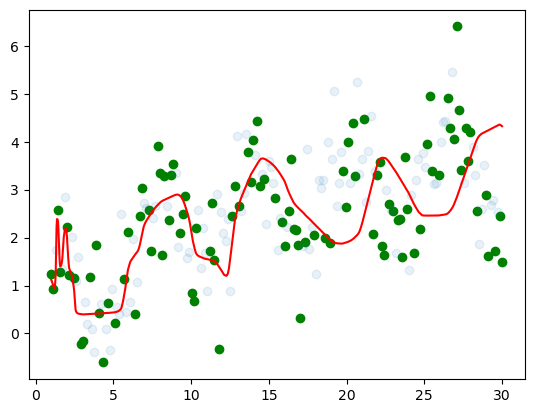

In [303]:
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, alpha=0.1)

x_seq = torch.linspace(start, end, 1000)[:, None].to(device)
# model.load_state_dict(torch.load('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best_model.pth'))
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

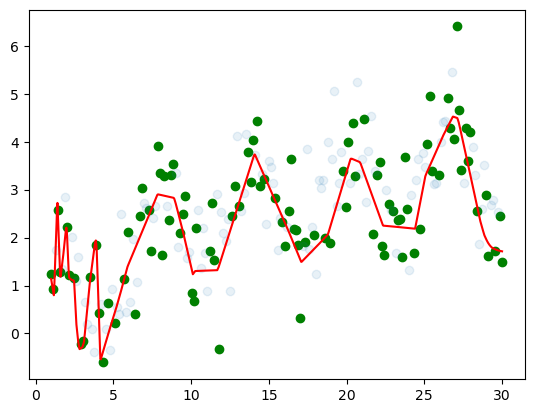

In [299]:
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, alpha=0.1)

x_seq = torch.linspace(start, end, 1000)[:, None].to(device)
# model.load_state_dict(torch.load('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best_model.pth'))
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')